In [120]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [121]:
!unzip /content/drive/MyDrive/KB/datasets.zip -d /content/

Archive:  /content/drive/MyDrive/KB/datasets.zip
replace /content/datasets/fruit/test/apple/images (1).jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: a
error:  invalid response [a]
replace /content/datasets/fruit/test/apple/images (1).jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: /content/datasets/fruit/test/apple/images (1).jpg  
  inflating: /content/datasets/fruit/test/apple/images (2).jpeg  
  inflating: /content/datasets/fruit/test/apple/images (3).jpg  
  inflating: /content/datasets/fruit/test/apple/images (4).jpg  
  inflating: /content/datasets/fruit/test/apple/images.jpg  
  inflating: /content/datasets/fruit/test/sirsak/images (1).jpeg  
  inflating: /content/datasets/fruit/test/sirsak/images (2).jpeg  
  inflating: /content/datasets/fruit/test/sirsak/images (3).jpeg  
  inflating: /content/datasets/fruit/test/sirsak/images (4).jpeg  
  inflating: /content/datasets/fruit/test/sirsak/images.jpeg  
  inflating: /content/datasets/fruit/train/apple/images (1).jpg  
  inf

# Imports library

In [122]:
# General Libs
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.inception_v3 import InceptionV3, preprocess_input
from tensorflow.keras.applications.inception_resnet_v2 import InceptionResNetV2, preprocess_input
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline

# Load dataset

In [123]:
#mendefinisikan dataset
im_shape = (299,299)

TRAINING_DIR = '/content/datasets/fruit/train'
TEST_DIR = '/content/datasets/fruit/test'

seed = 10

BATCH_SIZE = 2

In [124]:
#Using keras ImageGenerator and flow_from_directoty

ImageDataGenerator(
        validation_split=0.2,
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        preprocessing_function=preprocess_input,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest')
val_data_generator = ImageDataGenerator(preprocessing_function=preprocess_input,validation_split=0.2)

In [125]:
# Generator parameter train
train_generator = val_data_generator.flow_from_directory(TRAINING_DIR, target_size=im_shape, shuffle=True, seed=seed,
                                                     class_mode='categorical', batch_size=BATCH_SIZE, subset="training")
# Generator parameter validation
validation_generator = val_data_generator.flow_from_directory(TRAINING_DIR, target_size=im_shape, shuffle=False, seed=seed,
                                                     class_mode='categorical', batch_size=BATCH_SIZE, subset="validation")

# Generator dataset test
test_generator = ImageDataGenerator(preprocessing_function=preprocess_input)
test_generator = test_generator.flow_from_directory(TEST_DIR, target_size=im_shape, shuffle=False, seed=seed,
                                                     class_mode='categorical', batch_size=BATCH_SIZE)

nb_train_samples = train_generator.samples
nb_validation_samples = validation_generator.samples
nb_test_samples = test_generator.samples
classes = list(train_generator.class_indices.keys())
print('Classes: '+str(classes))
num_classes  = len(classes)

Found 8 images belonging to 2 classes.
Found 2 images belonging to 2 classes.
Found 10 images belonging to 2 classes.
Classes: ['apple', 'sirsak']


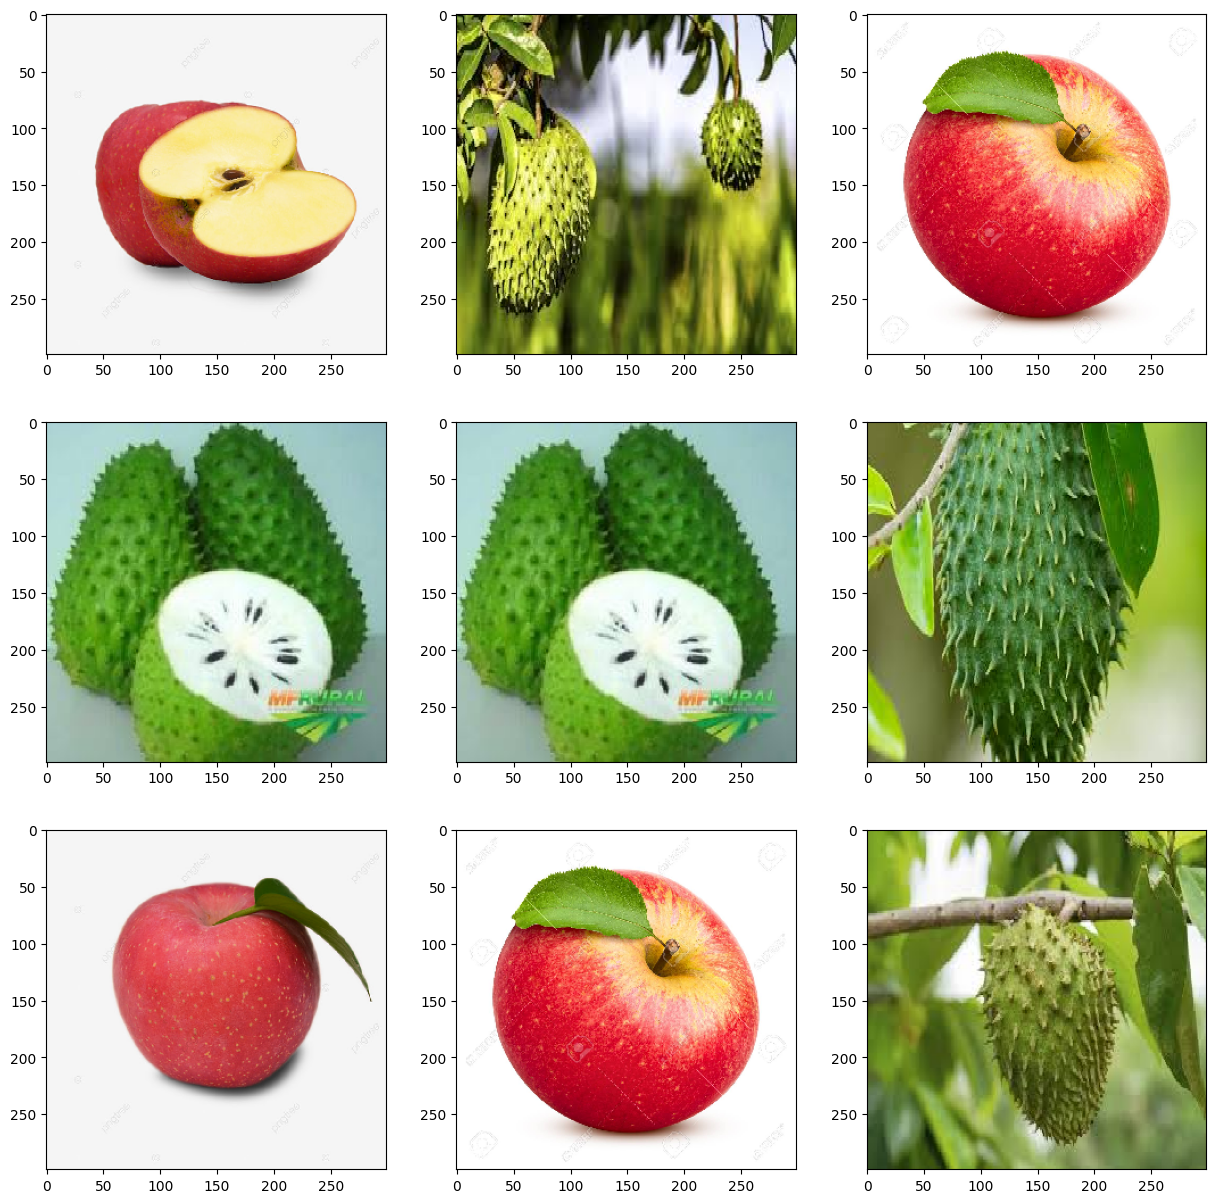

In [126]:
# Visualisasi beberapa contoh dataset melalui Generator yang dibuat
plt.figure(figsize=(15,15))
for i in range(9):
    plt.subplot(330 + 1 + i)
    batch = (train_generator.next()[0]+1)/2*255
    image = batch[0].astype('uint8')
    plt.imshow(image)
plt.show()

In [127]:
base_model = InceptionResNetV2(weights='imagenet',include_top=False, input_shape=(im_shape[0], im_shape[1], 3))

x = base_model.output
x = Flatten()(x)
x = Dense(100, activation='relu')(x)
predictions = Dense(num_classes, activation='softmax', kernel_initializer='random_uniform')(x)

model = Model(inputs=base_model.input, outputs=predictions)

base_model.trainable = False

optimizer = Adam()
model.compile(optimizer=optimizer,loss='categorical_crossentropy',metrics=['accuracy'])

In [128]:
epochs = 15

# Saving the best model
callbacks_list = [
    keras.callbacks.ModelCheckpoint(
        filepath='model.h5',
        monitor='val_loss', save_best_only=True, verbose=1),
    keras.callbacks.EarlyStopping(monitor='val_loss', patience=50,verbose=1)
]

history = model.fit(
        train_generator,
        steps_per_epoch=nb_train_samples // BATCH_SIZE,
        epochs=epochs,
        callbacks = callbacks_list,
        validation_data=validation_generator,
        verbose = 1,
        validation_steps=nb_validation_samples // BATCH_SIZE)

Epoch 1/15
4/4 [==============================] - ETA: 0s - loss: 6.7257 - accuracy: 0.5000
Epoch 1: val_loss improved from inf to 2.82487, saving model to model.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


4/4 [==============================] - 19s 2s/step - loss: 6.7257 - accuracy: 0.5000 - val_loss: 2.8249 - val_accuracy: 0.5000
Epoch 2/15
4/4 [==============================] - ETA: 0s - loss: 0.0022 - accuracy: 1.0000
Epoch 2: val_loss improved from 2.82487 to 0.00019, saving model to model.h5
4/4 [==============================] - 4s 1s/step - loss: 0.0022 - accuracy: 1.0000 - val_loss: 1.8576e-04 - val_accuracy: 1.0000
Epoch 3/15
4/4 [==============================] - ETA: 0s - loss: 0.0462 - accuracy: 1.0000
Epoch 3: val_loss did not improve from 0.00019
4/4 [==============================] - 0s 96ms/step - loss: 0.0462 - accuracy: 1.0000 - val_loss: 0.0015 - val_accuracy: 1.0000
Epoch 4/15
3/4 [=====================>........] - ETA: 0s - loss: 1.6788e-05 - accuracy: 1.0000
Epoch 4: val_loss improved from 0.00019 to 0.00002, saving model to model.h5
4/4 [==============================] - 2s 720ms/step - loss: 1.4826e-05 - accuracy: 1.0000 - val_loss: 1.5318e-05 - val_accuracy: 1.00

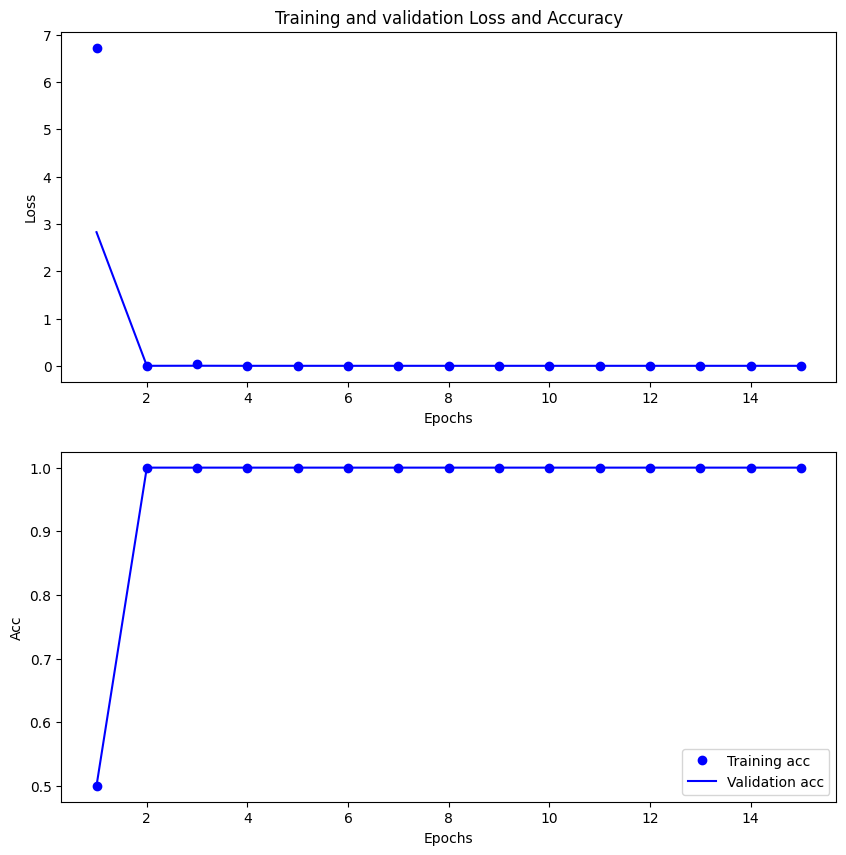

In [129]:
import matplotlib.pyplot as plt

history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']

epochs_x = range(1, len(loss_values) + 1)
plt.figure(figsize=(10,10))
plt.subplot(2,1,1)
plt.plot(epochs_x, loss_values, 'bo', label='Training loss')
plt.plot(epochs_x, val_loss_values, 'b', label='Validation loss')
plt.title('Training and validation Loss and Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
#plt.legend()
plt.subplot(2,1,2)
acc_values = history_dict['accuracy']
val_acc_values = history_dict['val_accuracy']
plt.plot(epochs_x, acc_values, 'bo', label='Training acc')
plt.plot(epochs_x, val_acc_values, 'b', label='Validation acc')
#plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Acc')
plt.legend()
plt.show()

In [130]:
from tensorflow.keras.models import load_model
# Load the best saved model
model = load_model('model.h5')

In [131]:
#model.summary()

In [132]:
# Using the validation dataset
score = model.evaluate_generator(validation_generator)
print('Val loss:', score[0])
print('Val accuracy:', score[1])

<ipython-input-132-0b1386c018fa>:2: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  score = model.evaluate_generator(validation_generator)


Val loss: 5.9604641222676946e-08
Val accuracy: 1.0


In [133]:
# Using the test dataset
score = model.evaluate_generator(test_generator)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

<ipython-input-133-8baddd65724c>:2: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  score = model.evaluate_generator(test_generator)


Test loss: 7.271760296134744e-07
Test accuracy: 1.0


In [134]:
import itertools

#Plot the confusion matrix. Set Normalize = True/False
def plot_confusion_matrix(cm, classes, normalize=True, title='Confusion matrix', cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure(figsize=(10,10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        cm = np.around(cm, decimals=2)
        cm[np.isnan(cm)] = 0.0
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

<ipython-input-135-c1926f3dc117>:6: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  Y_pred = model.predict_generator(test_generator)#, nb_test_samples // BATCH_SIZE, workers=1)


Classification Report
              precision    recall  f1-score   support

       apple       1.00      1.00      1.00         5
      sirsak       1.00      1.00      1.00         5

    accuracy                           1.00        10
   macro avg       1.00      1.00      1.00        10
weighted avg       1.00      1.00      1.00        10



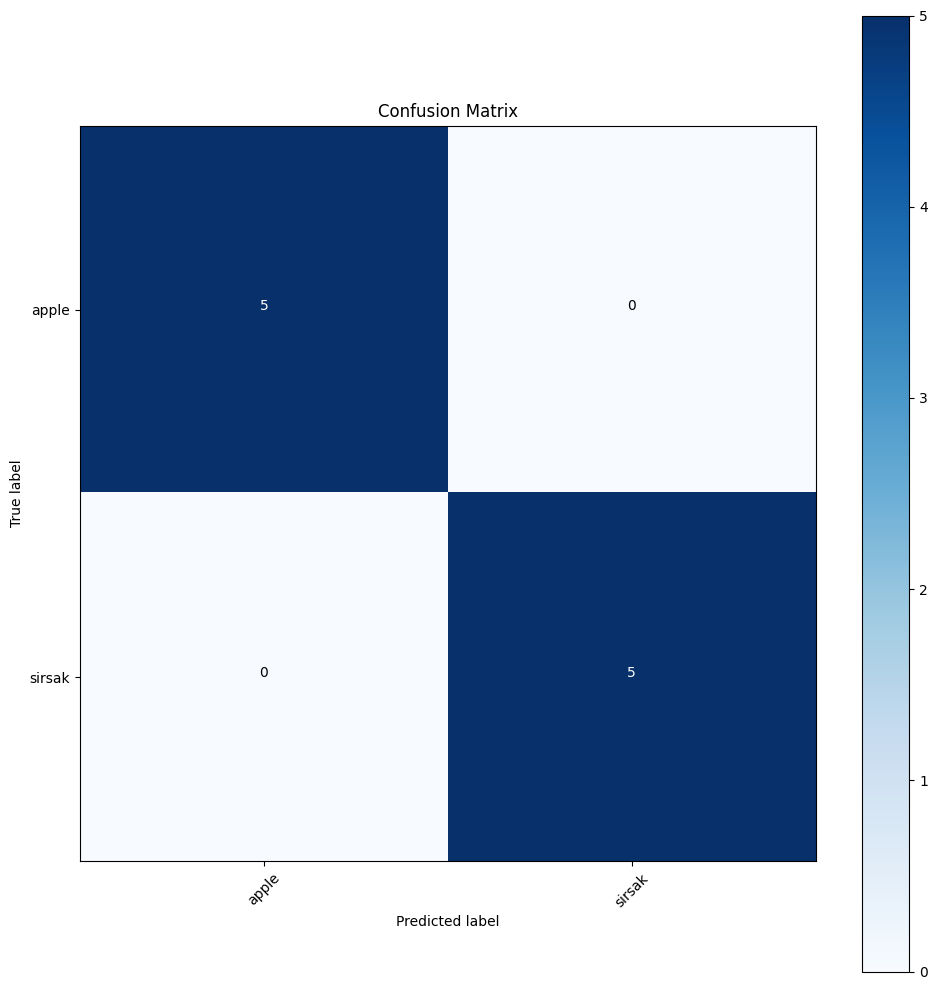

In [135]:
# Some reports
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

#Confution Matrix and Classification Report
Y_pred = model.predict_generator(test_generator)#, nb_test_samples // BATCH_SIZE, workers=1)
y_pred = np.argmax(Y_pred, axis=1)
target_names = classes

#Confution Matrix
cm = confusion_matrix(test_generator.classes, y_pred)
plot_confusion_matrix(cm, target_names, normalize=False, title='Confusion Matrix')
print('Classification Report')
print(classification_report(test_generator.classes, y_pred, target_names=target_names))

1/1 [==============================] - 4s 4s/step


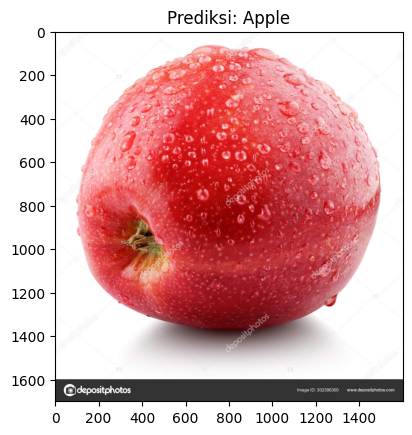

In [137]:
from keras.models import load_model
from keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt

# Muat kembali model
loaded_model = load_model('model.h5')

# Muat gambar uji
img_path = '/content/datasets/fruit/train/apple/images.jpg'
img = image.load_img(img_path, target_size=(299, 299))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)

# Normalisasikan gambar
img_array = img_array / 255.0

# Lakukan prediksi
prediction = loaded_model.predict(img_array)

# Interpretasi hasil prediksi
if prediction[0][0] > 0.5:
    label = "Apple"
else:
    label = "Sirsak"

# Tampilkan gambar dengan label prediksi
img = image.load_img(img_path)
plt.imshow(img)
plt.title(f'Prediksi: {label}')
plt.show()
